## Import libraries

In [1]:
from __future__ import division

from sqlalchemy import create_engine, MetaData, Table
import json
import math
import re
import csv
from itertools import izip_longest
from collections import Counter

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy.ma as ma

%matplotlib inline

/Users/kirstenziman/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
db_url = "sqlite:///../data/encoding/participants-test-room1.db"
table_name = 'turkdemo'
data_column_name = 'datastring'

# boilerplace sqlalchemy setup
engine = create_engine(db_url)
metadata = MetaData()
metadata.bind = engine
table = Table(table_name, metadata, autoload=True)

# make a query and loop through
s = table.select()
rows = s.execute()

data = []
for row in rows:
    data.append(row[data_column_name])
    
# Now we have all participant datastrings in a list.
# Let's make it a bit easier to work with:

# parse each participant's datastring as json object
# and take the 'data' sub-object
data = [json.loads(part)['data'] for part in data if part is not None]

# insert uniqueid field into trialdata in case it wasn't added
# in experiment:
for part in data:
    for record in part:
#         print(record)
        if type(record['trialdata']) is list:

            record['trialdata'] = {record['trialdata'][0]:record['trialdata'][1]}
        record['trialdata']['uniqueid'] = record['uniqueid']
        
# flatten nested list so we just have a list of the trialdata recorded
# each time psiturk.recordTrialData(trialdata) was called.
def isNotNumber(s):
    try:
        float(s)
        return False
    except ValueError:
        return True

data = [record['trialdata'] for part in data for record in part]

# filter out fields that we dont want using isNotNumber function
filtered_data = [{k:v for (k,v) in part.items() if isNotNumber(k)} for part in data]
    
# Put all subjects' trial data into a dataframe object from the
# 'pandas' python library: one option among many for analysis
data_frame = pd.DataFrame(filtered_data)

In [3]:
db_url = "sqlite:///../data/encoding/participants-test-room1.db"
table_name = 'turkdemo'
data_column_name = 'codeversion'

# boilerplace sqlalchemy setup
engine = create_engine(db_url)
metadata = MetaData()
metadata.bind = engine
table = Table(table_name, metadata, autoload=True)

# make a query and loop through
s = table.select()
rows = s.execute()

versions = []
version_dict = {}
for row in rows:
    version_dict[row[0]]=row[data_column_name]

    
version_col = []
for idx,sub in enumerate(data_frame['uniqueid'].unique()):
    for i in range(sum(data_frame['uniqueid']==sub)):
        version_col.append(version_dict[sub])
data_frame['exp_version']=version_col

In [4]:
# read in stimulus library
wordpool = pd.read_csv('../stimuli/cut_wordpool.csv')

In [5]:
# this function takes the data frame and returns subject specific data based on the subid variable
def filterData(data_frame,subid):
    filtered_stim_data = data_frame[data_frame['stimulus'].notnull() & data_frame['listNumber'].notnull()]
    filtered_stim_data = filtered_stim_data[filtered_stim_data['trial_type']=='single-stim']
    filtered_stim_data =  filtered_stim_data[filtered_stim_data['uniqueid']==subid]
    return filtered_stim_data

# this function parses the data creating an array of dictionaries, where each dictionary represents a trial (word presented) along with the stimulus attributes
def createStimDict(data):
    stimDict = []
    for index, row in data.iterrows():
        stimDict.append({
                'text': str(re.findall('>(.+)<',row['stimulus'])[0]),
                'color' : { 'r' : int(re.findall('rgb\((.+)\)',row['stimulus'])[0].split(',')[0]),
                           'g' : int(re.findall('rgb\((.+)\)',row['stimulus'])[0].split(',')[1]),
                           'b' : int(re.findall('rgb\((.+)\)',row['stimulus'])[0].split(',')[2])
                           },
                'location' : {
                    'top': float(re.findall('top:(.+)\%;', row['stimulus'])[0]),
                    'left' : float(re.findall('left:(.+)\%', row['stimulus'])[0])
                    },
                'category' : wordpool['CATEGORY'].iloc[list(wordpool['WORD'].values).index(str(re.findall('>(.+)<',row['stimulus'])[0]))],
                'size' : wordpool['SIZE'].iloc[list(wordpool['WORD'].values).index(str(re.findall('>(.+)<',row['stimulus'])[0]))],
                'wordLength' : len(str(re.findall('>(.+)<',row['stimulus'])[0])),
                'firstLetter' : str(re.findall('>(.+)<',row['stimulus'])[0])[0],
                'listnum' : row['listNumber']
            })
    return stimDict

# this function loads in the recall data into an array of arrays, where each array represents a list of words
def loadRecallData(subid):
    recalledWords = []
    for i in range(0,16):
        try:
            f = open('../data/recall/room1/' + subid + '/' + subid + '-' + str(i) + '.wav.txt', 'rb')
            spamreader = csv.reader(f, delimiter=' ', quotechar='|')
        except (IOError, OSError) as e:
            print(e)
        for row in spamreader:
            recalledWords.append(row[0].split(','))
    return recalledWords

# this function computes accuracy for a series of lists
def computeListAcc(stimDict,recalledWords):
    accVec = []
    for i in range(0,16):
        stim = [stim['text'] for stim in stimDict if stim['listnum']==i]
        recalled= recalledWords[i]
        
        acc = 0
        tmpstim = stim[:]
        for word in recalled:
            if word in tmpstim:
                tmpstim.remove(word)
                acc+=1
        accVec.append(acc/len(stim))
    return accVec

In [6]:
# subjects who have completed the exp
subids = list(data_frame[data_frame['listNumber']==15]['uniqueid'].unique())

subids.remove('debugAD2211:debugB3TKJQ') # this was Andy testing all the way through
subids.remove('debug7XDZDR:debugO8OCCV') # another test
subids.remove('debugTX7U35:debugZFTPLT') # another test - allison

pres_data = []
pres = []
rec = []


pres_exp1 = []
rec_exp1 = []
pres_exp2 = []
rec_exp2 = []
pres_exp3 = []
rec_exp3 = []
pres_exp4 = []
rec_exp4 = []
pres_exp5 = []
rec_exp5 = []

pres_all = []
rec_all = []


# for each subject that completed the experiment
for idx,sub in enumerate(subids):
    
    #print('Running analysis for subject: ', sub)    
        
    # get the subjects data
    filteredStimData = filterData(data_frame,sub)
    
    # parse the subjects data
    stimDict = createStimDict(filteredStimData)
    sub_data = pd.DataFrame(stimDict)
    sub_data['subject']=idx
    sub_data['experiment']=filteredStimData['exp_version'].values[0]
    sub_data = sub_data[['experiment','subject','listnum','text','category','color','location','firstLetter','size','wordLength']]
    
    pres_data.append(sub_data)
    pres.append([list(sub_data[sub_data['listnum']==lst]['text'].values) for lst in sub_data['listnum'].unique()])
    
    # load in the recall data
    recalledWords = loadRecallData(sub)
    rec.append(recalledWords)
    
    
    if filteredStimData['exp_version'].values[0]=='0.0':
        pres_exp1.append([list(sub_data[sub_data['listnum']==lst]['text'].values) for lst in sub_data['listnum'].unique()])
        rec_exp1.append(recalledWords)
        
    if filteredStimData['exp_version'].values[0]=='1.0':
        pres_exp1.append([list(sub_data[sub_data['listnum']==lst]['text'].values) for lst in sub_data['listnum'].unique()])
        rec_exp1.append(recalledWords)
        
    if filteredStimData['exp_version'].values[0]=='1.1':
        pres_exp1.append([list(sub_data[sub_data['listnum']==lst]['text'].values) for lst in sub_data['listnum'].unique()])
        rec_exp1.append(recalledWords)
        
    if filteredStimData['exp_version'].values[0]=='2.1':
        pres_exp2.append([list(sub_data[sub_data['listnum']==lst]['text'].values) for lst in sub_data['listnum'].unique()])
        rec_exp2.append(recalledWords)
        
    if filteredStimData['exp_version'].values[0]=='3.2':
        pres_exp3.append([list(sub_data[sub_data['listnum']==lst]['text'].values) for lst in sub_data['listnum'].unique()])
        rec_exp3.append(recalledWords)
        
    if filteredStimData['exp_version'].values[0]=='4.1':
        pres_exp4.append([list(sub_data[sub_data['listnum']==lst]['text'].values) for lst in sub_data['listnum'].unique()])
        rec_exp4.append(recalledWords)
        
    if filteredStimData['exp_version'].values[0]=='5.1':
        pres_exp5.append([list(sub_data[sub_data['listnum']==lst]['text'].values) for lst in sub_data['listnum'].unique()])
        rec_exp5.append(recalledWords)
        
    experiments = ['0.0', '1.0', '1.1', '2.1', '3.2', '4.1', '5.1']     
        
    if filteredStimData['exp_version'].values[0] in experiments:
        pres_all.append([list(sub_data[sub_data['listnum']==lst]['text'].values) for lst in sub_data['listnum'].unique()])
        rec_all.append(recalledWords)
        
        
pres_data = pd.concat(pres_data)

In [7]:
len(pres_all) == len(rec_all)

True

In [8]:
import pyrec as pyr

pyro_all = pyr.Pyro(pres = pres_all, rec = rec_all)
pyro_1 = pyr.Pyro(pres = pres_exp1, rec = rec_exp1)
pyro_2 = pyr.Pyro(pres = pres_exp2, rec = rec_exp2)
pyro_3 = pyr.Pyro(pres = pres_exp3, rec = rec_exp3)
pyro_4 = pyr.Pyro(pres = pres_exp4, rec = rec_exp4)
pyro_5 = pyr.Pyro(pres = pres_exp5, rec = rec_exp5)


<h1>Number of Subjects Per Experiment</h1>

In [9]:
print("experiment 1: ")
print(len(pres_exp1))
print 

print("experiment 2: ")
print(len(pres_exp2))
print

print("experiment 3: ")
print(len(pres_exp3))
print

print("experiment 4: ")
print(len(pres_exp4))
print

print("experiment 5: ")
print(len(pres_exp5))
print

experiment 1: 
21

experiment 2: 
21

experiment 3: 
22

experiment 4: 
23

experiment 5: 
15



<h1> SPC Average </h1>

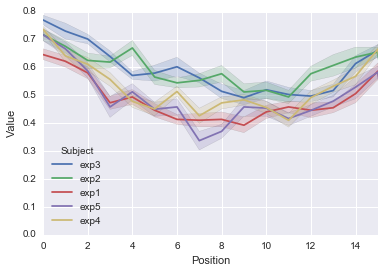

In [10]:
#AGGREGATE
spc_av = pyr.spc(pyro_all)#, listgroup = ['average']*16) 
pyr.plot(spc_av, plot_type = 'subject', subjgroup = ['exp1']*len(pres_exp1) + ['exp2']*len(pres_exp2) + ['exp3']*len(pres_exp3) + ['exp4']*len(pres_exp4) + ['exp5']*len(pres_exp5))

#INDIVIDUAL
# spc_single = pyr.spc(pyro_1)
# pyr.plot(spc_single)

<h1>PFR Average </h1>

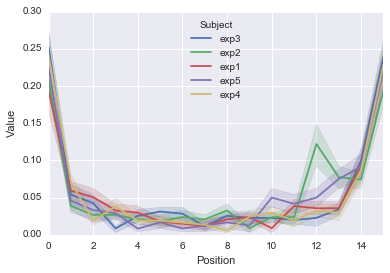

In [11]:
#AGGREGATE
pfr_av = pyr.pfr(pyro_all)#, listgroup = ['average']*16) 
pyr.plot(pfr_av, plot_type = 'subject', subjgroup = ['exp1']*len(pres_exp1) + ['exp2']*len(pres_exp2) + ['exp3']*len(pres_exp3) + ['exp4']*len(pres_exp4) + ['exp5']*len(pres_exp5))

#INDIVIDUAL
# pfr_single = pyr.pfr(pyro_1)
# pyr.plot(pfr_single)

<h1> PLR Average</h1>

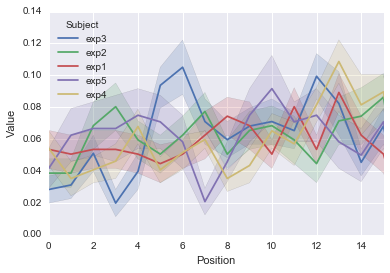

In [12]:
#AGGREGATE
plr_av = pyr.plr(pyro_all)#, listgroup = ['average']*16) 
pyr.plot(plr_av, plot_type = 'subject', subjgroup = ['exp1']*len(pres_exp1) + ['exp2']*len(pres_exp2) + ['exp3']*len(pres_exp3) + ['exp4']*len(pres_exp4) + ['exp5']*len(pres_exp5))
#INDIVIDUAL
# plr_single = pyr.plr(pyro_single)
# pyr.plot(plr_single)

<h1>Lag CRP, Average</h1>

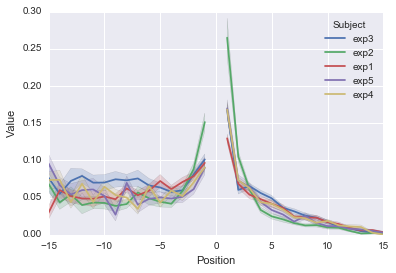

In [13]:
#AGGREGATE
lagcrp_av = pyr.lagcrp(pyro_all)#, listgroup = ['average']*16) 
pyr.plot(lagcrp_av, plot_type = 'subject', subjgroup = ['exp1']*len(pres_exp1) + ['exp2']*len(pres_exp2) + ['exp3']*len(pres_exp3) + ['exp4']*len(pres_exp4) + ['exp5']*len(pres_exp5))

#INDIVIDUAL
# lagcrp_single = pyr.lagcrp(pyro_single)
# pyr.plot(lagcrp_single)

<h1>Serial Position Curve, Early/Late Lists</h1>

In [14]:
spc2_av = pyr.spc(pyro)
pyr.plot(spc2_av, plot_type = 'subject', subjgroup = ['exp1']*len(pres_exp1) + ['exp2']*len(pres_exp2) + ['exp3']*len(pres_exp3) + ['exp4']*len(pres_exp4) + ['exp5']*len(pres_exp5))
#AGGREGATE
# spc_av = pyr.spc(pyro_all, listgroup = ['average']*16) 
# pyr.plot(spc_av, plot_type = 'subject', subjgroup = ['exp1']*21 + ['exp2']*21 + ['exp3']*22 + ['exp4']*23 + ['exp5']*15)

# #INDIVIDUAL
# # spc_single = pyr.spc(pyro_single)
# pyr.plot(spc_single)

NameError: name 'pyro' is not defined

<h1>PFR, Early/Late Lists</h1>

In [ ]:
fig = plt.figure()

print('Experiment 1')
pfr2 = pyr.pfr(pyro_1, listgroup=['early']*8 + ['late']*8)
fig_1 = pyr.plot(pfr2)
fig.add_subplot(321)

print('Experiment 2')
pfr3 = pyr.pfr(pyro_2, listgroup=['early']*8 + ['late']*8)
fig_2 = pyr.plot(pfr3)
fig.add_subplot(322)

print('Experiment 3')
pfr4 = pyr.pfr(pyro_3, listgroup=['early']*8 + ['late']*8)
fig_3 = pyr.plot(pfr4)
fig.add_subplot(323)

print('Experiment 4')
pfr5 = pyr.pfr(pyro_4, listgroup=['early']*8 + ['late']*8)
fig_4 = pyr.plot(pfr5)
fig.add_subplot(324)

print('Experiment 5')
pfr6 = pyr.pfr(pyro_5, listgroup=['early']*8 + ['late']*8)
fig_5 = pyr.plot(pfr6)


<h1>PLR, Early/Late Lists

In [ ]:
fig = plt.figure()

print('Experiment 1')
plr2 = pyr.plr(pyro_1, listgroup=['early']*8 + ['late']*8)
fig_1 = pyr.plot(plr2)
fig.add_subplot(321)

print('Experiment 2')
plr3 = pyr.plr(pyro_2, listgroup=['early']*8 + ['late']*8)
fig_2 = pyr.plot(plr3)
fig.add_subplot(322)

print('Experiment 3')
plr4 = pyr.plr(pyro_3, listgroup=['early']*8 + ['late']*8)
fig_3 = pyr.plot(plr4)
fig.add_subplot(323)

print('Experiment 4')
plr5 = pyr.plr(pyro_4, listgroup=['early']*8 + ['late']*8)
fig_4 = pyr.plot(plr5)
fig.add_subplot(324)

print('Experiment 5')
plr6 = pyr.plr(pyro_5, listgroup=['early']*8 + ['late']*8)
fig_5 = pyr.plot(plr6)

<h1>Lag CRP, Early/Late Lists

In [ ]:
fig = plt.figure()

print('Experiment 1')
lagcrp2 = pyr.lagcrp(pyro_1, listgroup=['early']*8 + ['late']*8)
fig_1 = pyr.plot(lagcrp2)
fig.add_subplot(321)

print('Experiment 2')
lagcrp3 = pyr.lagcrp(pyro_2, listgroup=['early']*8 + ['late']*8)
fig_2 = pyr.plot(lagcrp3)
fig.add_subplot(322)

print('Experiment 3')
lagcrp4 = pyr.lagcrp(pyro_3, listgroup=['early']*8 + ['late']*8)
fig_3 = pyr.plot(lagcrp4)
fig.add_subplot(323)

print('Experiment 4')
lagcrp5 = pyr.lagcrp(pyro_4, listgroup=['early']*8 + ['late']*8)
fig_4 = pyr.plot(lagcrp5)
fig.add_subplot(324)

print('Experiment 5')
lagcrp6 = pyr.lagcrp(pyro_5, listgroup=['early']*8 + ['late']*8)
fig_5 = pyr.plot(lagcrp6)

<h1>SPC, by Subject

In [ ]:
# spc = pyr.spc(pyro, listgroup=['average']*16)
# pyr.plot(spc, plot_type='grid')#, subjgroup = ['exp1']*21 + ['exp2']*21 + ['exp3']*22 + ['exp4']*23 + ['exp5']*15 )


<h1>PFR, by Subject

In [ ]:
# pfr = pyr.pfr(pyro, listgroup=['average']*16)
# pyr.plot(pfr, plot_type='subject')

<h1>PLR, by Subject</h1>

In [ ]:
# plr = pyr.plr(pyro, listgroup=['average']*16)
# pyr.plot(plr, plot_type='subject')

<h1>Lag CRP, by Subject

In [22]:
# lagcrp = pyr.lagcrp(pyro, listgroup=['average']*16)
# ax = pyr.plot(lagcrp, plot_type='subject')